In [407]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Geod
import folium   # using folium to display the data on a map

import plotly.graph_objects as go
import plotly
import chart_studio.plotly as py
import plotly.express as px


In [408]:
%run load_data.ipynb 

In [409]:
data = load_processed_data()

In [411]:
data_daily = data.groupby(["date"]).started_at.count()

In [412]:
# get df for weekly data, take the first date of each week as label
data_weekly = data.groupby(['year','week'])[['started_at']].agg(['count','first']).reset_index()

# rename the multilevel columns to a combination of the two levels 
data_weekly.columns = ['_'.join(tup) if tup[1] != '' else tup[0] for tup in list(data_weekly.columns)]

In [413]:
# make a dictionary of some important Covid Dates in UK

covid_times = {#'First UK Case': pd.to_datetime('2020-01-31'),
                'More countries requiring self-isolation': pd.to_datetime('2020-02-06'),
              #'8 Confirmed UK': pd.to_datetime('2020-02-10'),
              #'442,000 Calls to Hotline in Week': pd.to_datetime('2020-02-29'),
              'First Fatality': pd.to_datetime('2020-03-05'),
              'Declared Pandemic': pd.to_datetime('2020-03-11'),
            #'Scottish Universites work from home': pd.to_datetime('2020-03-18'),
              #'Risk in UK Moderate to High': pd.to_datetime('2020-03-12'),
              #'Announced Future Self-Isolation for Vulnerable': pd.to_datetime('2020-03-15'),
              #'PM Warning Against Non-essential contact and Travel': pd.to_datetime('2020-03-16'),
              'Lockdown': pd.to_datetime('2020-03-23'),
              #'Warning issued to Households': pd.to_datetime('2020-03-29'),
              #'Queen\'s Address': pd.to_datetime('2020-04-05')}
                'Easter Weekend': pd.to_datetime('2020-04-10')}

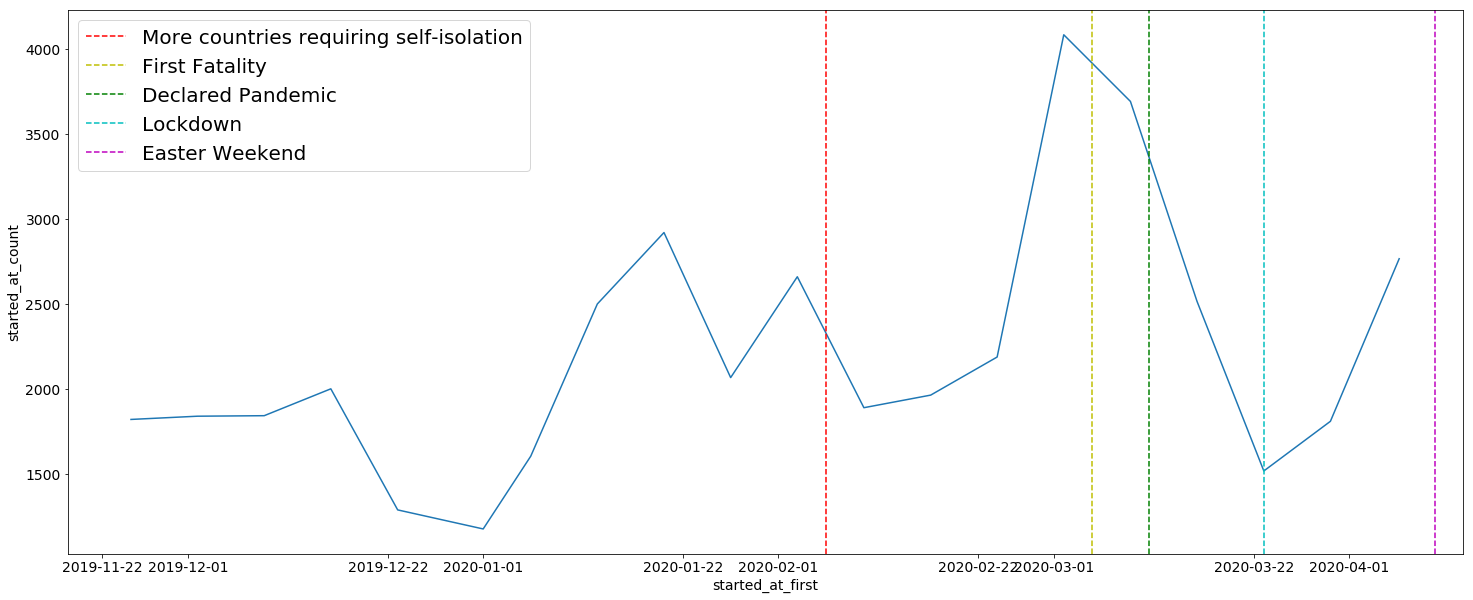

In [416]:
# plot the weekly bike data with first date of week

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.lineplot(x=data_weekly.started_at_first[-20:], y=data_weekly.started_at_count[-20:], ax=ax)

# x coordinates for the lines
xcoords = list(covid_times.values())
labels = list(covid_times.keys())
colors = ['r','y','g','c','m']
for xc,lab,c in zip(xcoords,labels, colors):
    plt.axvline(x=xc, label=lab.format(xc), color=c, linestyle='--')

plt.legend(loc=2, prop={'size': 20})
plt.show()
plt.show()

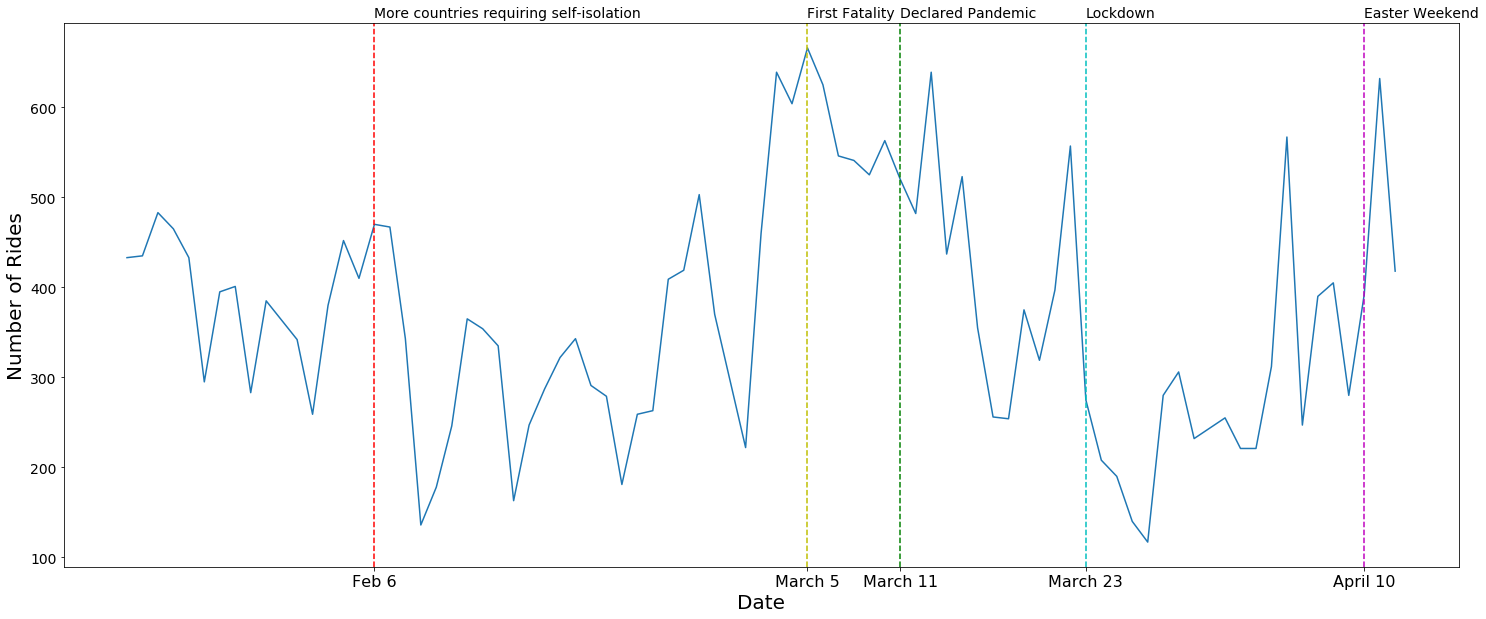

In [417]:
%matplotlib inline

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.lineplot(x=data_daily.index[-80:], y=data_daily[-80:], ax=ax)

# x coordinates for the lines
xcoords = list(covid_times.values())
labels = list(covid_times.keys())
colors = ['r','y','g','c','m']
for xc,lab,c in zip(xcoords,labels, colors):
    plt.axvline(x=xc, label=lab.format(xc), color=c, linestyle='--')
    plt.text(xc,700,lab,rotation=0)

    
plt.xticks(xcoords, labels = ['Feb 6','March 5','March 11','March 23','April 10'], fontsize=16)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Rides', fontsize=20)
#plt.legend(loc=2, prop={'size': 20})
plt.show()
plt.show()
#plt.savefig('Daily_Rides.pdf')

In [425]:
data.groupby(['year','month'])['end_station_name'].nunique()

year  month
2019  1         53
      2         50
      3         53
      4         75
      5         81
      6         83
      7         66
      8         72
      9         77
      10        83
      11        85
      12        89
2020  1         93
      2         98
      3        108
      4        102
Name: end_station_name, dtype: int64

In [438]:
rides_April_df = data[(data.year == 2020) & (data.month == 4)].groupby(
    'start_station_name')[['started_at',
                           'start_station_latitude',
                           'start_station_longitude']].agg(
    {'started_at': 'count','start_station_latitude': 'first',
     'start_station_longitude': 'first'}).rename(columns = {'started_at': 'rides'}).reset_index()

In [439]:
rides_April_df.to_csv('rides_April_data.csv', index=False)

### Compare Stations before and after March 2020

In [426]:
# make a bool column with True if March 2020 or later, or False if before March 2020 (before covid-19 rise)
data['after_covid'] = data.started_at.dt.date >= pd.to_datetime('2020-03-01')

In [427]:
# dataframe for average monthly rides in Jan and Feb 2020 for each station
before_covid_rides = (data[(data.after_covid == False) &
                           (data.year == 2020)].groupby(
    'end_station_name')[['duration']].count()/2).reset_index().rename(columns = {'duration': 'before_covid_rides'})

# dataframe for average monthly rides in March and April 2020 for each station
after_covid_rides = (data[data.after_covid == True].groupby(
    'end_station_name')[['duration']].count()/1.33).reset_index().rename(columns = {'duration': 'after_covid_rides'})

# merge rides before and after March into one single dataframe
covid_rides_df = before_covid_rides.merge(after_covid_rides, on='end_station_name')

In [421]:
# compare the monthly average rides before and after March 2020 in a scatter plot

fig = px.scatter(covid_rides_df, x = 'before_covid_rides',y = 'after_covid_rides', 
                 hover_data = ['end_station_name'])
fig.update_layout(title='Comparison of Average Monthly Rides per Station Before and After March 2020',
                  xaxis_title="Monthly Rides Before COVID-19", 
                  yaxis_title="Monthly Rides After COVID-19",)
fig.show()

In [422]:
# dataframe for average monthly rides in Jan and Feb 2020 for each station
before_covid_rides = (data[(data.after_covid == False) &
                           (data.year == 2020) & (data.is_weekend == False)].groupby(
    'end_station_name')[['duration']].count()/2).reset_index().rename(columns = {'duration': 'before_covid_rides'})

# dataframe for average monthly rides in March and April 2020 for each station
after_covid_rides = (data[(data.after_covid == True) & (data.is_weekend == False)].groupby(
    'end_station_name')[['duration']].count()/1.33).reset_index().rename(columns = {'duration': 'after_covid_rides'})

# merge rides before and after March into one single dataframe
covid_rides_df = before_covid_rides.merge(after_covid_rides, on='end_station_name')

In [423]:
# compare the monthly average rides before and after March 2020 in a scatter plot

fig = px.scatter(covid_rides_df, x = 'before_covid_rides',y = 'after_covid_rides', 
                 hover_data = ['end_station_name'])
fig.update_layout(title='Comparison of Average Monthly Rides per Station Before and After March 2020',
                  xaxis_title="Monthly Rides Before COVID-19", 
                  yaxis_title="Monthly Rides After COVID-19",)
fig.show()

### Make a Sankey Plot

In [204]:
# mask out less common starting stations for plot

values = data.start_station_name.copy()
counts = data.start_station_name.value_counts()
top_stations = counts.iloc[:8].index
# set all listings that have any of those top 20 amenities to true (to make the mask)
mask = values.isin(top_stations)
# mask out amenities that are not in the top 20 most popular
values[~mask] = 'Other'

data['start_masked'] = values

In [205]:
# mask out less common end stations for plot:
values = data.end_station_name.copy()
counts = data.end_station_name.value_counts()
top_stations = counts.iloc[:8].index
# set all listings that have any of those top 20 amenities to true (to make the mask)
mask = values.isin(top_stations)
# mask out amenities that are not in the top 20 most popular
values[~mask] = 'Other'

data['end_masked'] = values
#end_stations = pd.DataFrame(values.value_counts()).reset_index()

In [207]:
# make network df for plot
sankey_df = data.groupby(['start_masked','end_masked'])[['end_masked']].count().rename(
    columns = {'end_masked':'count'}).reset_index()

In [226]:
df = sankey_df.copy()
value_cols = 'count'
cat_cols = ['start_masked','end_masked']
colorPalette = ['#FFE873','#646464','#4B8BBE','#306998','#FFD43B']

# list of all start stations + end stations in order
labelList = list(sankey_df.start_masked.unique()) + list(sankey_df.end_masked.unique())

colorNumList = []
for catCol in cat_cols:
    labelListTemp =  list(set(df[catCol].values))
    colorNumList.append(len(labelListTemp))
    labelList = labelList + labelListTemp
    
# transform df into a source-target pair
for i in range(len(cat_cols)-1):
    if i==0:
        sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
        sourceTargetDf.columns = ['source','target','count']
    else:
        tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
        tempDf.columns = ['source','target','count']
        sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
    sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
    
# define colors based on number of levels
colorList = []
for idx, colorNum in enumerate(colorNumList):
    colorList = colorList + [colorPalette[idx]]*colorNum
    
# make a dictionary for the start station indices and then the end station indices with none overapping, 
# or else the plot will make circular connections
labels_start = dict(zip(list(df.start_masked.unique()), range(df.start_masked.nunique())))
labels_end = dict(zip(list(df.end_masked.unique()), 
                      range(df.start_masked.nunique(),df.start_masked.nunique()+ df.end_masked.nunique())))

sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labels_start[x])
sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labels_end[x])

In [227]:
# make sankey plot

fig = go.Figure(data = [go.Sankey(
    node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
    link = dict(
        source = sourceTargetDf['sourceID'],
        target = sourceTargetDf['targetID'],
        value = sourceTargetDf['count']
        ))])

In [228]:
fig.show()

In [236]:
# remove masking columns from main dataframe

data.drop(columns = ['start_masked','end_masked'], inplace = True)

### Find differences before and after "lockdown"

In [253]:
data['after_covid'] = data.started_at.dt.date >= pd.to_datetime('2020-03-22')

The total number of visited stations before the lockdown: 161


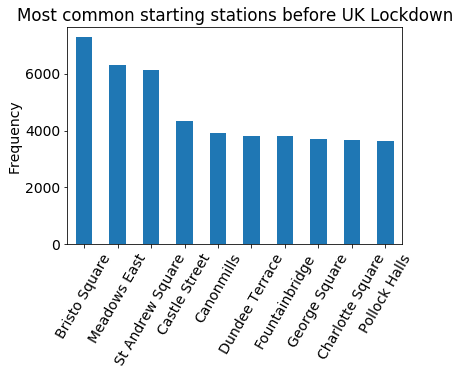

The total number of visited stations after the lockdown: 105


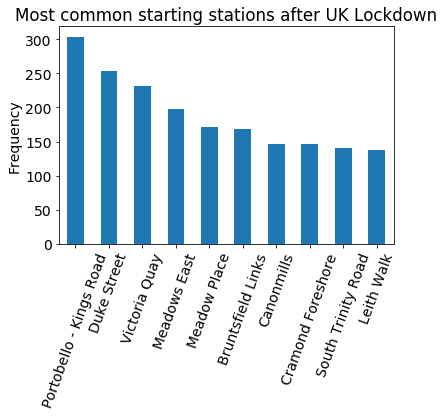

In [258]:
all_stations = data[data.after_covid == False][['start_station_name','end_station_name']].melt()
station_counts = all_stations.iloc[:,1].value_counts()
print("The total number of visited stations before the lockdown: %d" % len(station_counts))

# See how many times each start station occurs
start_stations = data[data.after_covid == False]['start_station_name']
start_station_counts = start_stations.value_counts()

# Take the ten most common start stations and plot
start_station_counts[0:10].plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('Most common starting stations before UK Lockdown')
plt.show()

all_stations = data[data.after_covid == True][['start_station_name','end_station_name']].melt()
station_counts = all_stations.iloc[:,1].value_counts()
print("The total number of visited stations after the lockdown: %d" % len(station_counts))

# See how many times each start station occurs
start_stations = data[data.after_covid == True]['start_station_name']
start_station_counts = start_stations.value_counts()

# Take the ten most common start stations and plot
start_station_counts[0:10].plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.title('Most common starting stations after UK Lockdown')
plt.show()

The total number of visited stations before the lockdown: 53


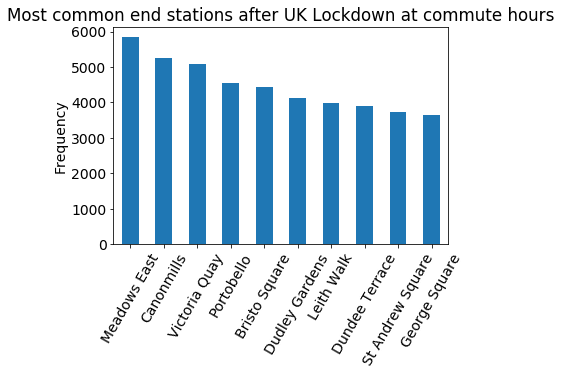

In [301]:
all_stations = data[(data.after_covid == True) & (data.end_hour == 8) &
                    (data.end_hour <= 9)][['end_station_name']].melt()
station_counts = all_stations.iloc[:,1].value_counts()
print("The total number of visited stations before the lockdown: %d" % len(station_counts))

# See how many times each start station occurs
end_stations = data[data.after_covid == False]['end_station_name']
end_station_counts = end_stations.value_counts()

# Take the ten most common start stations and plot
end_station_counts[0:10].plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('Most common end stations after UK Lockdown at commute hours')
plt.show()

,day_of_week,day_name
0,1,Tuesday
172,2,Wednesday
325,3,Thursday
475,4,Friday
642,5,Saturday
791,6,Sunday
944,0,Monday


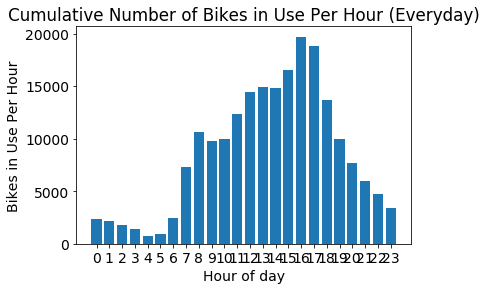

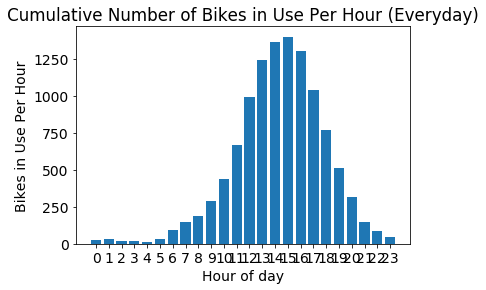

In [276]:
def list_hours(entry):
    '''
    A function to create a list containing the hours in which 
    the journey is being undertaken
    Input: entry - an entry from our dataframe (data)
    Output: a list containing all the hours travelled in
        e.g. if the journey began Monday 11am and ended 2pm, 
        this would output [11,12,13,14]
    '''
    return list(range(entry['start_hour'],entry['end_hour']+1,1))

def plot_hours_use(data, option = None):
    if option == 'weekday':
        data = data[data.day_name.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]
    elif option == 'weekend':
        data = data[data.day_name.isin(['Saturday','Sunday'])]
    # Apply list_hours function to each row in dataframe data
    all_hours_list = list(data.apply(list_hours,axis=1))

    # Flatten the list of lists generated for each time range
    flat_hours_list = [item for sublist in all_hours_list for item in sublist]

    plt.hist(flat_hours_list,rwidth=0.8,range=(0,24),bins=np.arange(25)-0.5)
    plt.xticks(np.arange(0,24, 1))
    plt.xlabel('Hour of day')
    plt.ylabel('Bikes in Use Per Hour')
    plt.title('Cumulative Number of Bikes in Use Per Hour (Everyday)')
    plt.show()

    
plot_hours_use(data[data.after_covid == False])

plot_hours_use(data[data.after_covid])


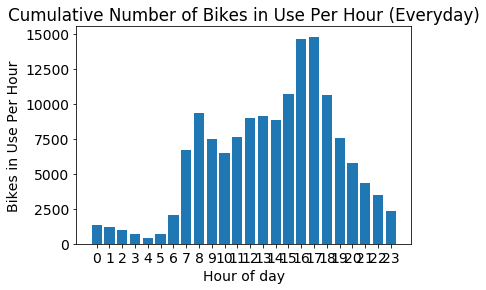

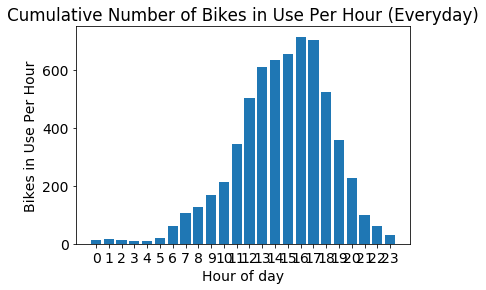

In [277]:
plot_hours_use(data[data.after_covid == False], option = 'weekday')

plot_hours_use(data[data.after_covid], option= 'weekday')

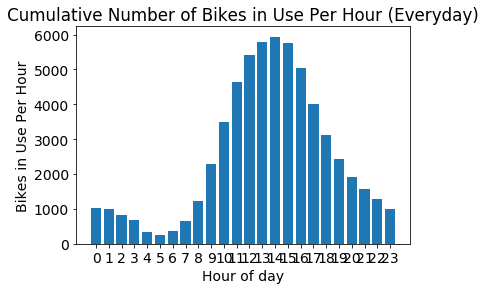

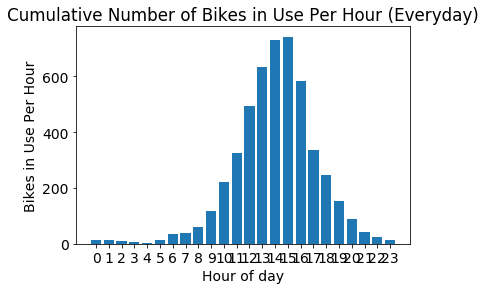

In [280]:
plot_hours_use(data[data.after_covid == False], option = 'weekend')

plot_hours_use(data[data.after_covid], option= 'weekend')

### Maps

In [284]:

# Using folium to display geographical data
# choose coordinates based off of the average latitude and longitude
# from the data set to initialise the map to
folium_map_lines = folium.Map(location=[55.950500, -3.185805],
                        zoom_start=12,
                        tiles="CartoDB dark_matter")


def map_at_hour(start_hour, color_choice,folium_map):
    '''
    A function for adding PolyLines to a folium map 
    Inputs: start_hour - the hour at which journeys will be plotted on the map
            color_choice - choice of color of the lines
            folium_map - specific folium map the lines should be added to
    No output - adds the lines to previously defined
    Should call the map afterwards to display
    '''
    # Refine the dataframe to only contain entries starting at start_hour
    data_at_hour = data[(data.after_covid) & (data['start_hour'] == start_hour)]

    # Iterate through the rows of data_at_hour adding a PolyLine formed by 
    # start and end coordinates of the journey in color_choice, add to folium_map
    for ind,row in data_at_hour.iterrows():
        tup1 = (data.start_station_latitude[ind], data.start_station_longitude[ind])
        tup2 = (data.end_station_latitude[ind], data.end_station_longitude[ind])
        folium.PolyLine([tup1,tup2], color=color_choice, opacity=.2).add_to(folium_map)
        

# Display the folium map for plotting all journeys starting between 8am and 9am
# NOTE: can simply change 8 to any hour between 0 and 24 to see the journeys 
# undertaken in that hour mapped
map_at_hour(23,"#E37222",folium_map_lines)
folium_map_lines



In [294]:
# Extra investigation into data:
# Display how popular each station is to start at by size of circle on map
# Allows for easier visualisation of most popular stations
# (the second question)

# redefine the folium map to plot onto
folium_map_stations = folium.Map(location=[55.950500, -3.185805],
                        zoom_start=12,
                        tiles="CartoDB dark_matter")

start_stations = data[data.after_covid == False]['start_station_name']    # take only column with start stations
station_counts = start_stations.value_counts()   # count number of times each station occurs
# Turn the resulting value counts into a dataframe, easier to deal with
station_counts = pd.DataFrame({'station_name':station_counts.index, 'counts':station_counts.values})

# Get all stations by taking the first row entry for every 
# different station ID (after grouping data by station ID)
station_locs = data[data.after_covid == False].groupby('start_station_id').first()
# Get the locations of each start station from these rows
station_locs = station_locs.loc[:, ['start_station_latitude','start_station_longitude','start_station_name']]

# Iterate through each column, row pair
# to add the count number to folium map as 
# radius of the circle located at that station
for col,row in station_locs.iterrows():
    name = station_locs.start_station_name[col]   # get start station name
    count_num = station_counts[station_counts['station_name']==name].iloc[0,1]
    circle_rad = float(count_num)/300   # scale the radius of the circle
    folium.CircleMarker(location=(row['start_station_latitude'],
                                  row['start_station_longitude']),
                        radius=circle_rad,
                        color="#0A8A9F",
                        fill=True).add_to(folium_map_stations)
    
    
print('Map of popular stations before lockdown')
# Display most popular stations on a map based on size of circle at location    
folium_map_stations


Map of popular stations before lockdown


In [295]:
# Extra investigation into data:
# Display how popular each station is to start at by size of circle on map
# Allows for easier visualisation of most popular stations
# (the second question)

# redefine the folium map to plot onto
folium_map_stations = folium.Map(location=[55.950500, -3.185805],
                        zoom_start=12,
                        tiles="CartoDB dark_matter")

start_stations = data[data.after_covid]['start_station_name']    # take only column with start stations
station_counts = start_stations.value_counts()   # count number of times each station occurs
# Turn the resulting value counts into a dataframe, easier to deal with
station_counts = pd.DataFrame({'station_name':station_counts.index, 'counts':station_counts.values})

# Get all stations by taking the first row entry for every 
# different station ID (after grouping data by station ID)
station_locs = data[data.after_covid].groupby('start_station_id').first()
# Get the locations of each start station from these rows
station_locs = station_locs.loc[:, ['start_station_latitude','start_station_longitude','start_station_name']]

# Iterate through each column, row pair
# to add the count number to folium map as 
# radius of the circle located at that station
for col,row in station_locs.iterrows():
    name = station_locs.start_station_name[col]   # get start station name
    count_num = station_counts[station_counts['station_name']==name].iloc[0,1]
    circle_rad = float(count_num)/20   # scale the radius of the circle
    folium.CircleMarker(location=(row['start_station_latitude'],
                                  row['start_station_longitude']),
                        radius=circle_rad,
                        color="#0A8A9F",
                        fill=True).add_to(folium_map_stations)

print('Map of popular stations after lockdown')
# Display most popular stations on a map based on size of circle at location    
folium_map_stations


Map of popular stations after lockdown
